##### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('owid-energy-data.csv')
df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,1900,AFG,4832414.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1901,AFG,4879685.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1902,AFG,4935122.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1903,AFG,4998861.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1904,AFG,5063419.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21890 entries, 0 to 21889
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.5+ MB


In [4]:
cols = pd.read_excel('energy_data.xlsx', sheet_name = 'owid-energy-codebook')
cols = cols['columns']

## Data cleaning - Time period selecton based on NaN values
We find a reasonable amount of NaN values that we accept based on the NaN counts across all year.

Another consideration is the time period has to be recent, hence we start from 2022 and work backwards.

In [5]:
# for year 2021, this is the number of NaN values across the columns
df[df['year'] == 2021].isna().sum().sum()

14184

In [6]:
# initialise new dataframe to store NaN counts
nan_count = pd.DataFrame(columns=['year', 'nan_counts'])

In [7]:
# for each year in the dataset, tally the number of NaN values to determine which year to cut off onwards
# takes quite a while to append (around 35s)
for year in df['year']:
    count = df[df['year'] == year].isna().sum().sum()
    row = [year, count]
    row_df = pd.DataFrame([row], columns = nan_count.columns)
    nan_count = pd.concat([nan_count, row_df], ignore_index=True)

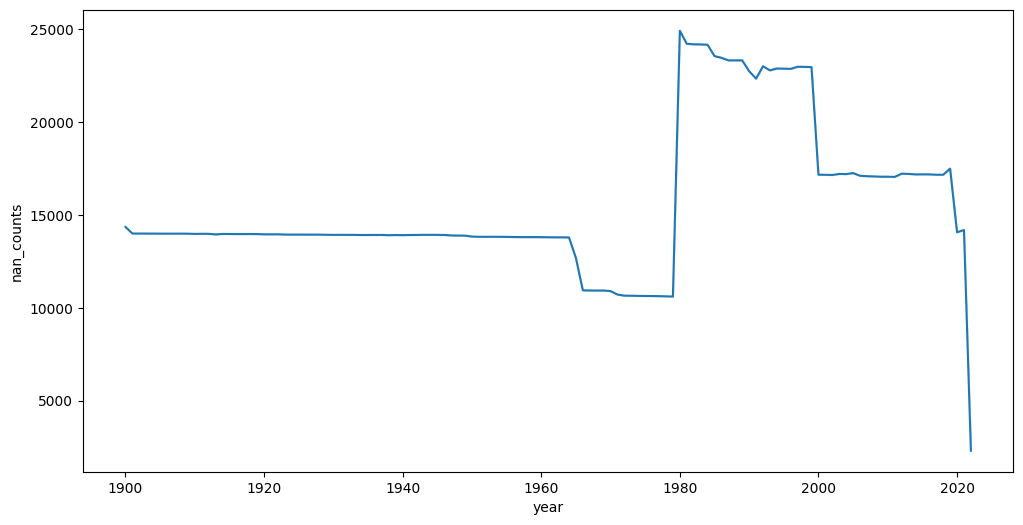

In [8]:
# from the graph, we backtrack to a reasonable time period where null values are at an acceptable range - around year 2000
figure = plt.figure(figsize=(12,6))
sb.lineplot(data=nan_count, x = 'year', y = 'nan_counts');

Hence we restrict the years to year 2000 onwards for subsequent analysis

In [9]:
df = df[df['year'] > 1999]

## Data Cleaning: Column Filtering based on relevancy

Filter out columns that are too specific and are not 'per capita' or the like - we may get back to them later but this step narrows our focus down to more relevant data

We want to compare the relative changes in the various energy consumption/generation. 

We keep some absolute metrics that are more general like greenhouse gas emissions, fossil fuel consumption etc. as it still gives us a brief overview on what to focus on.

In [10]:
# hardcoded the index to remove -> refer to excel where it represents the start of the red-highlighted rows
rm_cols = ['biofuel_consumption', 'biofuel_electricity', 'coal_cons_change_twh', 'coal_consumption', 'coal_electricity', 
           'coal_prod_change_twh', 'coal_production', 'electricity_generation', 'fossil_cons_change_twh', 'gas_cons_change_twh', 
           'gas_consumption', 'gas_electricity', 'gas_prod_change_twh', 'gas_production', 'hydro_cons_change_twh', 'hydro_consumption', 
           'hydro_electricity', 'low_carbon_cons_change_twh', 'net_elec_imports', 'nuclear_cons_change_twh', 'nuclear_consumption', 
           'nuclear_electricity', 'oil_cons_change_twh', 'oil_consumption', 'oil_electricity', 'oil_prod_change_twh', 'oil_production', 
           'other_renewable_consumption', 'other_renewable_electricity', 'other_renewable_exc_biofuel_electricity', 'other_renewables_cons_change_twh', 
           'per_capita_electricity', 'primary_energy_consumption', 'renewables_cons_change_twh', 'solar_cons_change_twh', 'solar_consumption', 'solar_electricity', 
           'wind_cons_change_twh', 'wind_consumption', 'wind_electricity']

In [11]:
# drop less relevant columns
df1 = df.drop(columns = rm_cols)
df1

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_elec_per_capita,biofuel_share_elec,...,solar_cons_change_pct,solar_elec_per_capita,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_elec_per_capita,wind_energy_per_capita,wind_share_elec,wind_share_energy
100,Afghanistan,2000,AFG,19542986.0,1.128379e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
101,Afghanistan,2001,AFG,19688634.0,1.102127e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
102,Afghanistan,2002,AFG,21000258.0,1.880487e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
103,Afghanistan,2003,AFG,22645136.0,2.107434e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
104,Afghanistan,2004,AFG,23553554.0,2.233257e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,Zimbabwe,2017,ZWE,14751101.0,2.194784e+10,NaN,NaN,NaN,21.693,4.354,...,NaN,0.678,NaN,0.136,NaN,NaN,0.0,NaN,0.0,NaN
21886,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,NaN,NaN,NaN,25.910,4.244,...,NaN,1.329,NaN,0.218,NaN,NaN,0.0,NaN,0.0,NaN
21887,Zimbabwe,2019,ZWE,15354606.0,NaN,NaN,NaN,NaN,24.748,4.612,...,NaN,1.954,NaN,0.364,NaN,NaN,0.0,NaN,0.0,NaN
21888,Zimbabwe,2020,ZWE,15669663.0,NaN,NaN,NaN,NaN,22.336,4.605,...,NaN,1.915,NaN,0.395,NaN,NaN,0.0,NaN,0.0,NaN


### Data Cleaning - Column filtering based on NaN values

Note that a lot of the NaN values are attributed to the nature of the data - not all countries have the ability to produce wind energy for example

Hence, for starters, we only narrow it down further as the EDA becomes more specific - for now, we take note of the columns with significant NaN values.

In [12]:
pct_null = df1.isnull().sum() / len(df1)
pct_null.sort_values(ascending=False).head(10)

biofuel_cons_per_capita             0.911414
biofuel_cons_change_pct             0.897476
biofuel_share_energy                0.880750
biofuel_cons_change_twh             0.880750
nuclear_cons_change_pct             0.831501
solar_cons_change_pct               0.737030
wind_cons_change_pct                0.723091
nuclear_energy_per_capita           0.722007
other_renewables_cons_change_pct    0.712870
fossil_energy_per_capita            0.697383
dtype: float64

## Exploratory Data Analysis - Continents + Countries
First, we remove rows in 'country' column that are not considered countries - such as G7, G20, Yugoslavia, Czechoslovakia

In [13]:
# countries.csv is extracted from online where it contains ISO 3166-1 alpha-3 codes of 193 recognised countries
iso_codes = pd.read_csv('countries.csv')
alpha3 = iso_codes['alpha3'].apply(str.upper).unique()
len(alpha3)

193

In [14]:
# you can tell that there are 6 missing countries in the dataframe
iso_countries = df1[df1['iso_code'].isin(alpha3)]['iso_code'].unique()
len(iso_countries)

187

In [15]:
# make alpha3 into a dataframe (from a numpy array) to check for missing countries
df_alpha3 = pd.DataFrame(alpha3)

mis_countries = df_alpha3[~df_alpha3.isin(iso_countries)].dropna()
mis_countries

,0
3,AND
99,LIE
108,MHL
114,MCO
132,PLW
148,SMR


The officially recognised countries (based on ISO 3166-1 alpha3 codes) not included are: **Andorra, Liechtenstein, Marshall Islands, Monacoo, Palau and San Marino**

We don't need to include their data as they are relatively small countries

We include continents for a broad analysis before diving into individual countries (without (Ember), (Shift) and (BP) as they are merely subsets of the continents themselves)

In [16]:
# initialise new dataframe with valid countries + continents
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
df2 = pd.concat([df1[df1['iso_code'].isin(iso_countries)], df1[df1['country'].isin(continents)]], ignore_index=True)
df2

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_elec_per_capita,biofuel_share_elec,...,solar_cons_change_pct,solar_elec_per_capita,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_elec_per_capita,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,2000,AFG,19542986.0,1.128379e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
1,Afghanistan,2001,AFG,19688634.0,1.102127e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
2,Afghanistan,2002,AFG,21000258.0,1.880487e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
3,Afghanistan,2003,AFG,22645136.0,2.107434e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
4,Afghanistan,2004,AFG,23553554.0,2.233257e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,South America,2017,NaN,420982650.0,NaN,NaN,NaN,NaN,137.963,5.101,...,73.117,12.970,34.534,0.480,0.205,26.642,121.834,326.810,4.505,1.943
4244,South America,2018,NaN,424740741.0,NaN,NaN,NaN,NaN,141.710,5.204,...,85.822,24.438,63.231,0.897,0.384,16.051,141.380,373.713,5.192,2.268
4245,South America,2019,NaN,428318218.0,NaN,NaN,NaN,NaN,138.192,5.113,...,53.422,35.838,95.845,1.326,0.593,20.999,167.913,446.758,6.213,2.763
4246,South America,2020,NaN,431530105.0,NaN,NaN,NaN,NaN,147.962,5.508,...,38.566,49.707,131.337,1.850,0.875,9.645,182.791,484.414,6.805,3.228


### Comparison across __continents__ with identified parameters

We use fossil fuels and renewable energy to compare non-renewable vs renewable energy

We leave out nuclear energy (i.e. not using low carbon sources) as the UN's focus is more on fossil fuels and renewables.

In [17]:
continent_data = df2[df2['country'].isin(continents)]

In [18]:
continent_metrics = ['population', 'greenhouse_gas_emissions', 'fossil_fuel_consumption', 
                     'renewables_consumption', 'fossil_cons_change_pct', 'renewables_cons_change_pct',
                     'fossil_share_energy', 'renewables_share_energy']

In [19]:
# we use the .copy() function so that we make our own edits based on the new dataframe, not on the original dataframe
continent_general_data = continent_data[['year', 'country'] + continent_metrics].reset_index().copy()
continent_general_data.drop(columns = 'index', inplace=True)
continent_general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   year                        132 non-null    int64  
 1   country                     132 non-null    object 
 2   population                  132 non-null    float64
 3   greenhouse_gas_emissions    132 non-null    float64
 4   fossil_fuel_consumption     132 non-null    float64
 5   renewables_consumption      132 non-null    float64
 6   fossil_cons_change_pct      132 non-null    float64
 7   renewables_cons_change_pct  132 non-null    float64
 8   fossil_share_energy         132 non-null    float64
 9   renewables_share_energy     132 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 10.4+ KB


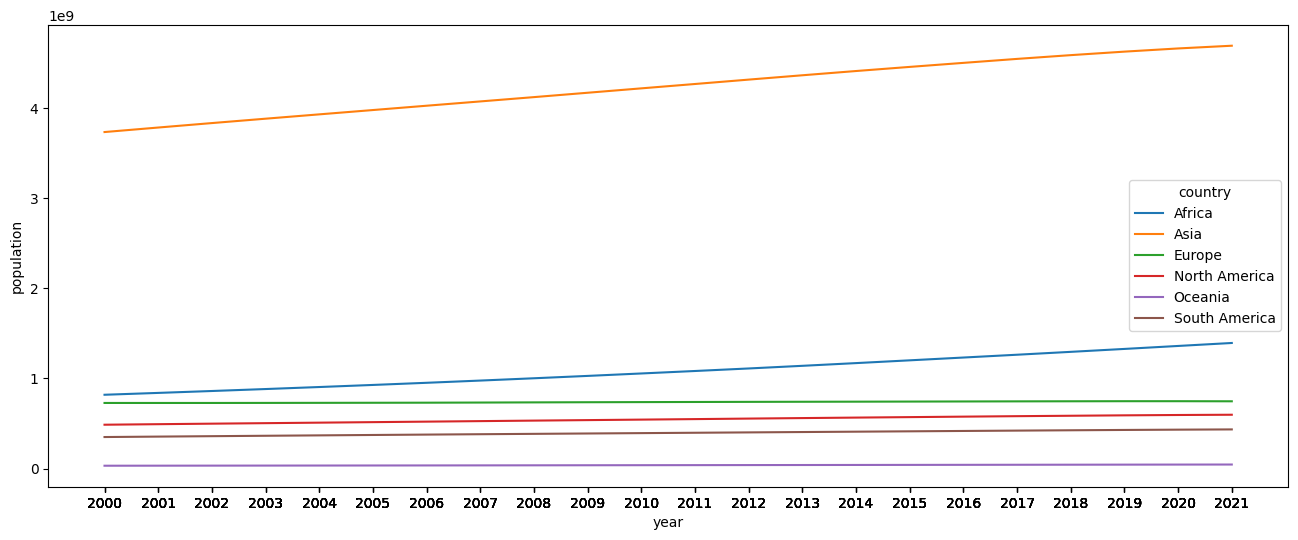

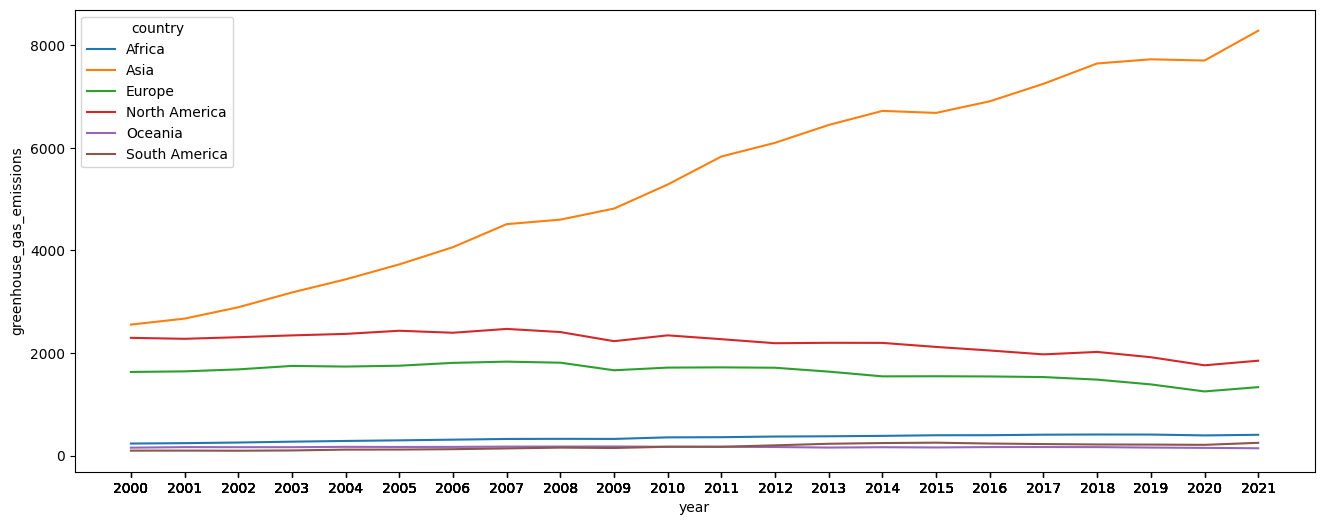

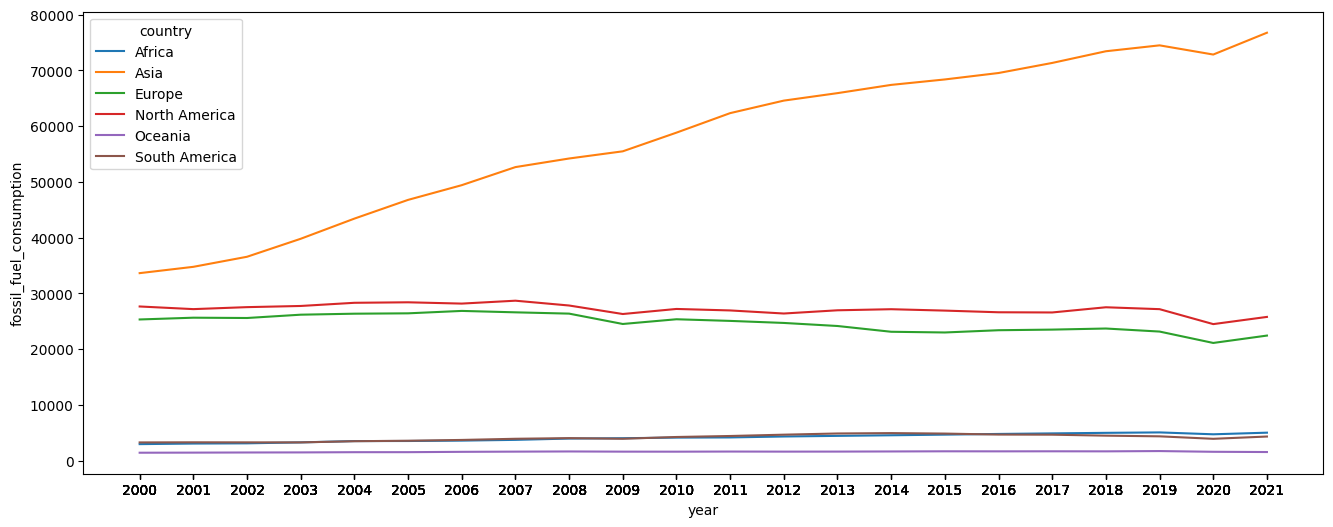

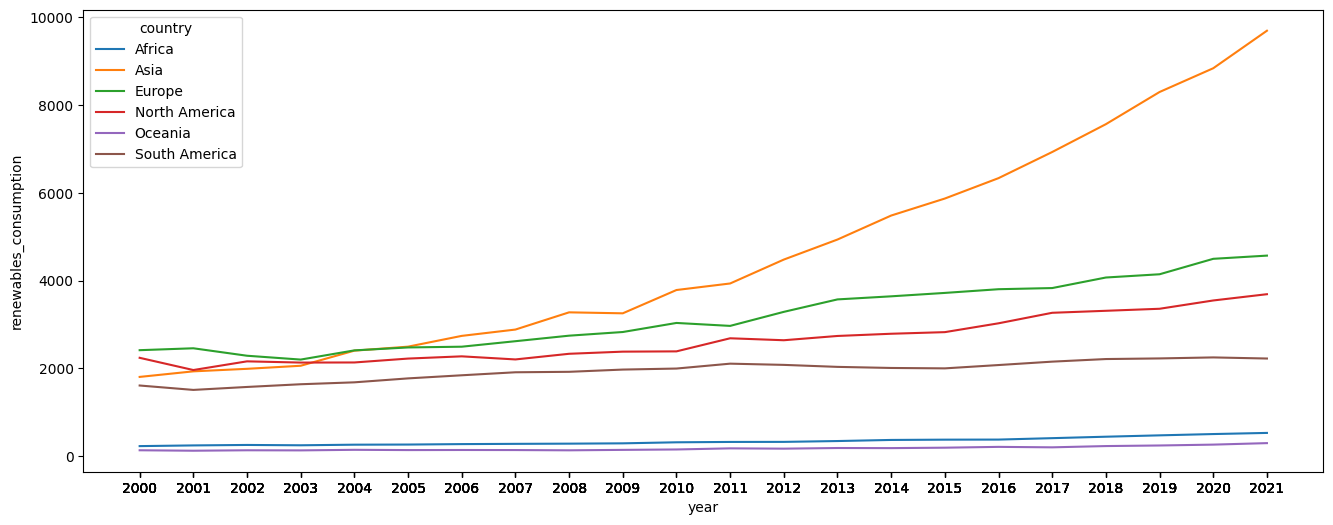

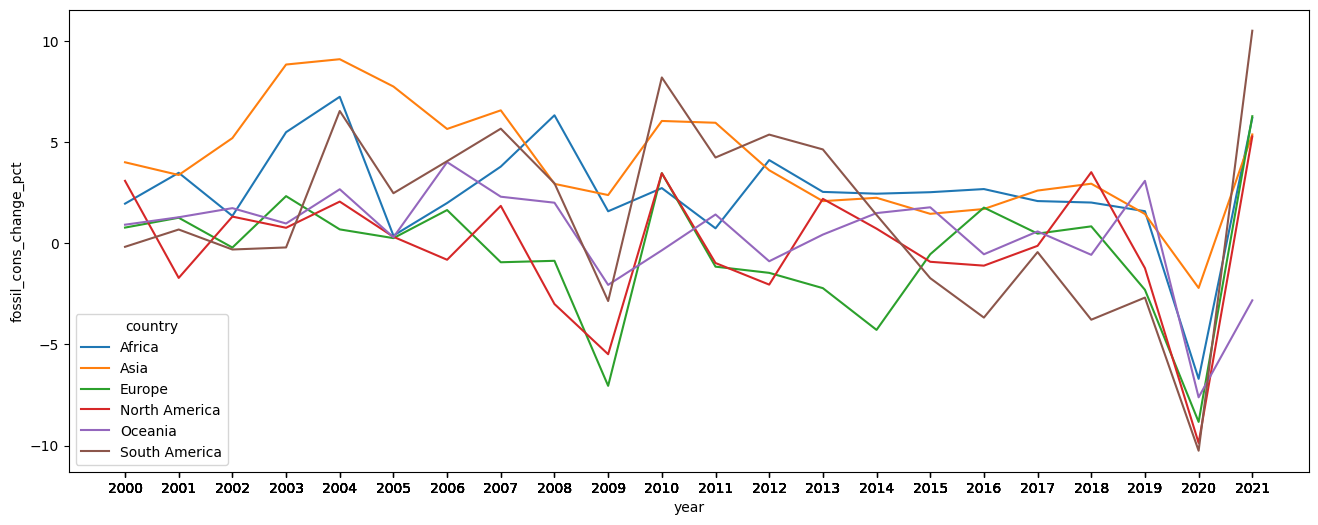

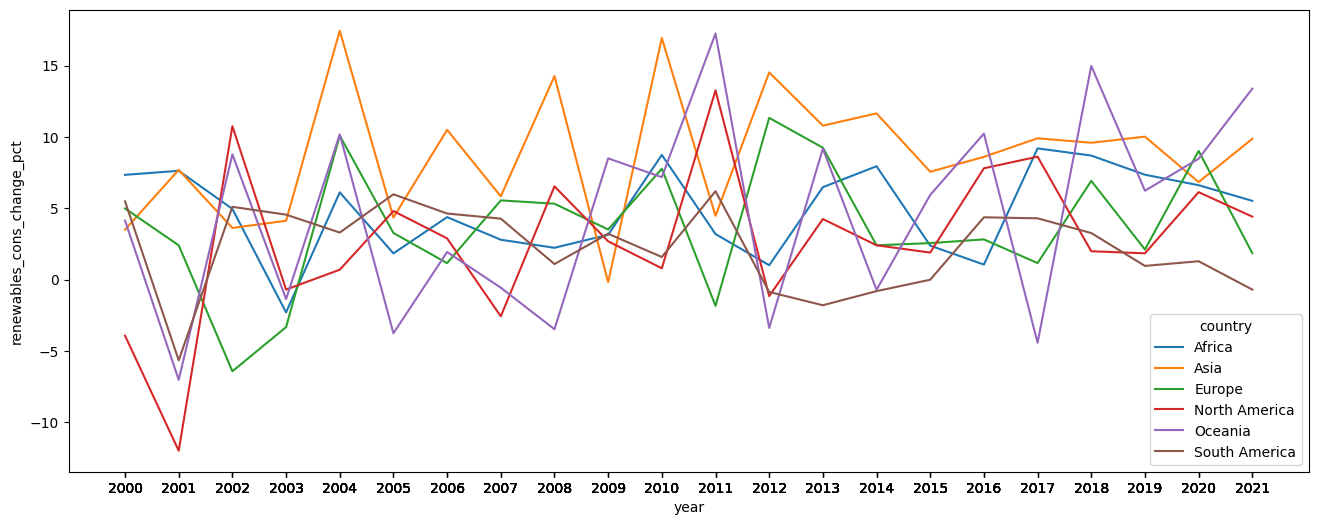

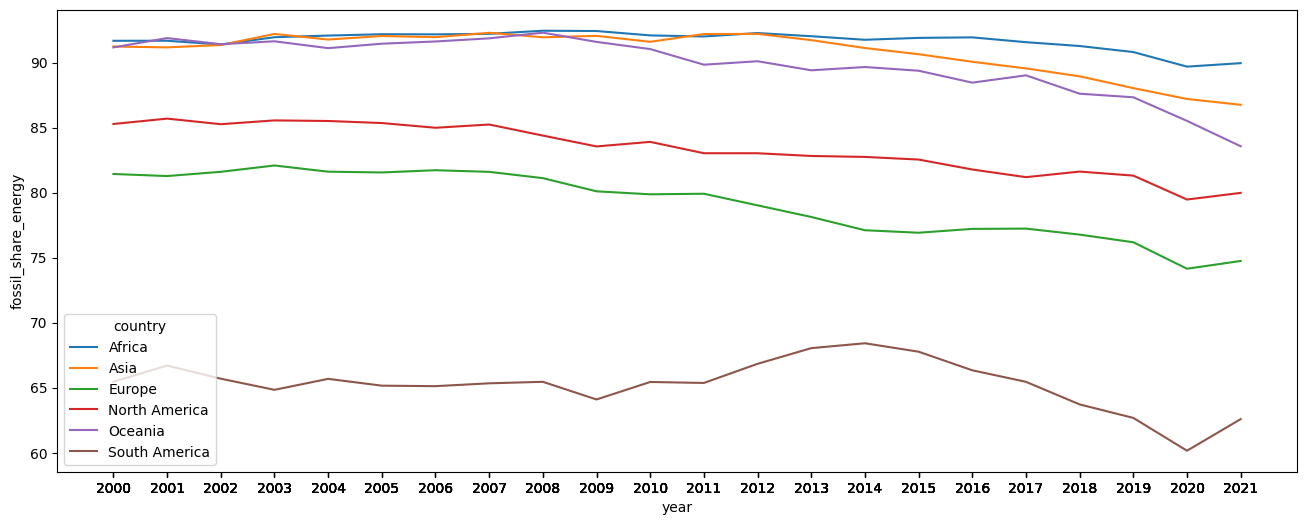

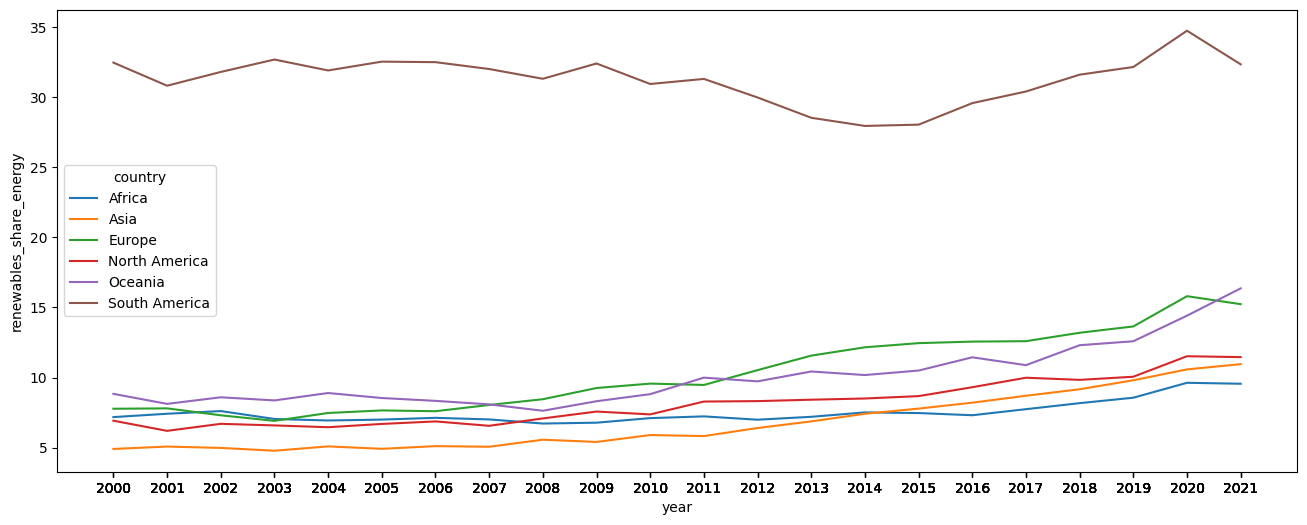

In [20]:
for metric in continent_metrics:
    figure = plt.figure(figsize=(16,6))
    sb.lineplot(data=continent_general_data, x = 'year', y = metric, hue = 'country')
    plt.xticks(continent_general_data["year"].astype(int))

Notice the following:
- **population**: Asia has a significant increase compared to other countries, Africa has a slight increase as well

- **greenhouse_gas_emissions**: Asia is the largest contributor

- **fossil_fuel_consumption**: Asia is the largest contributor

- **renewables_consumption**: Asia is the largest contributor & it looks more exponential than fossil fuel consumption

- **fossil_cons_change_pct**: Significant spikes upwards across all continents after 2020 - likely due to COVID-19 pandemic reopening

- **renewables_cons_change_pct**: Values for all continents remains in the positive change - means increase in renewable consumption

- **fossil_share_energy**: South America remains low (60-70%) compared to other continents (75%++). Africa and Asia has the highest percentages.

- **renewables_share_energy**: South America remains high (30%) compared to other continents (<15%). From 2012 onwards, a gradual rise from all countries


With this information, we can conclude that:

_While there are increase in fossil fuel consumption is attributed to population increase AND increase in fossil fuel energy usage is met with an increase in renewable energy usage, we still see that fossil fuel reliance is high in most continents with percentages higher than 70% other than South America._

### Comparison across __countries__ with identified parameters

We use fossil fuels and renewable energy to compare non-renewable vs renewable energy, similar to continent comparison.

For countries, we decide to use choropleths for data visualisation to easily, at a glance, see countries at the ends of each spectrum

**For this notebook, we get imports and set everything up to be working offline for plotly.**

In [21]:
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# This allows figures to show up on the notebook
init_notebook_mode(connected=True) 

In [22]:
# initialise countries dataframe for the 187 countries identified
country_data = df2[df2['iso_code'].isin(iso_countries)].copy()
country_data.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_elec_per_capita,biofuel_share_elec,...,solar_cons_change_pct,solar_elec_per_capita,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_elec_per_capita,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,2000,AFG,19542986.0,1.128379e+10,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
1,Afghanistan,2001,AFG,19688634.0,1.102127e+10,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
2,Afghanistan,2002,AFG,21000258.0,1.880487e+10,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
3,Afghanistan,2003,AFG,22645136.0,2.107434e+10,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
4,Afghanistan,2004,AFG,23553554.0,2.233257e+10,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN


In [23]:
null_mask = country_data.isnull()
null_mask.groupby(country_data['year']).sum().sum(axis=1).sort_values().head()

year
2022    1404
2011    5263
2002    5266
2010    5270
2016    5271
dtype: int64

2022 has the least number of null values - we will mainly refer our data to 2022 data

In [24]:
# Note that the metrics are the same as continent_metrics, but with gdp_per_capita
country_metrics = ['population', 'greenhouse_gas_emissions', 'fossil_fuel_consumption', 
                     'renewables_consumption', 'fossil_cons_change_pct', 'renewables_cons_change_pct',
                     'fossil_share_energy', 'renewables_share_energy']


In [25]:
country_general_data = country_data[['year', 'country', 'iso_code'] + country_metrics].reset_index().copy()
country_general_data.drop(columns='index', inplace=True)
country_general_data.head()

,year,country,iso_code,population,greenhouse_gas_emissions,fossil_fuel_consumption,renewables_consumption,fossil_cons_change_pct,renewables_cons_change_pct,fossil_share_energy,renewables_share_energy
0,2000,Afghanistan,AFG,19542986.0,0.12,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,Afghanistan,AFG,19688634.0,0.07,NaN,NaN,NaN,NaN,NaN,NaN
2,2002,Afghanistan,AFG,21000258.0,0.10,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,Afghanistan,AFG,22645136.0,0.24,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,Afghanistan,AFG,23553554.0,0.24,NaN,NaN,NaN,NaN,NaN,NaN


#### Choropleth for greenhouse gas emissions (2021)

In [26]:
# spread is large - we will use logarithmic scale to plot the choropleth
country_2021 = country_general_data[country_general_data['year'] == 2021]

In [27]:
data = dict(type = 'choropleth',
            locations = country_2021['iso_code'],
            z = np.log10(country_2021['greenhouse_gas_emissions']),
            text = country_2021['country'],
            colorbar = {'title' : 'Greenhouse Gas Emissions'},
            colorscale = 'YlOrRd')

c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10



In [28]:
layout = dict(title = '2022 Greenhouse Gas Emissions', geo = dict(showframe = True, projection = {'type':'natural earth'}), margin = dict(l=0, r=0, t=0, b=0))

In [29]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

### Classification of Developed/Developing Countries:

As the nature of the classification is binary and the data is not labelled as 'developed' or 'developing', we will use an unsupervised clustering algorithm to define which is developed or developing - K-Means Clustering with 2 clusters.

__In general, countries in clusters with high values are 'developed' while clusters with low values are 'developing'__

We evaluate the credibility of our model with:
1. Silhouette score: The silhouette score measures how well each data point fits into its assigned cluster, based on how similar it is to the other points in its own cluster compared to the points in the other clusters. A higher silhouette score indicates that the clusters are well separated and that the data points are well matched to their assigned clusters.

2. Within-cluster sum of squares (WCSS): WCSS measures the sum of the squared distances between each data point and the centroid of its assigned cluster. A lower WCSS indicates that the clusters are more tightly packed and that the data points are more similar to each other within each cluster.

In [30]:
country_data['country'].value_counts().sort_values().head(7)

South Sudan             10
Montenegro              17
Timor                   19
Micronesia (country)    20
Tuvalu                  20
Albania                 21
Barbados                22
Name: country, dtype: int64

As the original dataset has a lot of missing GDP values as well as missing countries for certain years, we will use external dataset to use for our first round of clustering

GDP per capita - 2021 values (external data set - World Bank)

HDI - 2021 values (external data set - UNHDR)

In [31]:
original_df = country_data[['country', 'iso_code','year']]
original_df.head()

,country,iso_code,year
0,Afghanistan,AFG,2000
1,Afghanistan,AFG,2001
2,Afghanistan,AFG,2002
3,Afghanistan,AFG,2003
4,Afghanistan,AFG,2004


In [32]:
hdi_data = pd.read_excel('HDR21-22_Statistical_Annex_HDI_Table.xlsx')
hdi_data = hdi_data.iloc[8:201, 1:3].reset_index().drop(columns='index')

In [33]:
hdi_data = hdi_data.rename(columns={'Table 1. Human Development Index and its components' : 'country', 'Unnamed: 2' : 'HDI'})
hdi_data = hdi_data.sort_values(by = 'HDI').dropna()
hdi_data

,country,HDI
192,Chad,0.394
191,Niger,0.4
190,Central African Republic,0.404
189,Burundi,0.426
188,Mali,0.428
...,...,...
4,Australia,0.951
3,"Hong Kong, China (SAR)",0.952
2,Iceland,0.959
1,Norway,0.961


In [34]:
gdppc_data = pd.read_excel('energy_data.xlsx', sheet_name = 'gdp per capita')
gdppc_data = gdppc_data.iloc[:, [1] + list(range(42, len(gdppc_data.columns)))]
gdppc_data = gdppc_data.rename(columns={'Country Code' : 'iso_code'})

In [35]:
gdppc_data_melted = gdppc_data.melt(id_vars='iso_code', var_name='year', value_name='gdp_per_capita')
gdppc_data_melted['year'] = gdppc_data_melted['year'].astype('int64')

In [36]:
merged_df = pd.merge(original_df, gdppc_data_melted, on=['iso_code', 'year'], how='left')
merged_df

,country,iso_code,year,gdp_per_capita
0,Afghanistan,AFG,2000,NaN
1,Afghanistan,AFG,2001,NaN
2,Afghanistan,AFG,2002,183.532775
3,Afghanistan,AFG,2003,200.462567
4,Afghanistan,AFG,2004,221.657604
...,...,...,...,...
4111,Zimbabwe,ZWE,2017,1192.107012
4112,Zimbabwe,ZWE,2018,2269.177012
4113,Zimbabwe,ZWE,2019,1421.868596
4114,Zimbabwe,ZWE,2020,1372.696674


In [37]:
final_df = pd.merge(merged_df, hdi_data, on='country', how='left')
final_df

,country,iso_code,year,gdp_per_capita,HDI
0,Afghanistan,AFG,2000,NaN,0.478
1,Afghanistan,AFG,2001,NaN,0.478
2,Afghanistan,AFG,2002,183.532775,0.478
3,Afghanistan,AFG,2003,200.462567,0.478
4,Afghanistan,AFG,2004,221.657604,0.478
...,...,...,...,...,...
4111,Zimbabwe,ZWE,2017,1192.107012,0.593
4112,Zimbabwe,ZWE,2018,2269.177012,0.593
4113,Zimbabwe,ZWE,2019,1421.868596,0.593
4114,Zimbabwe,ZWE,2020,1372.696674,0.593


In [38]:
fdf = final_df['gdp_per_capita'].isnull()
fdf.groupby(final_df['country']).sum().sort_values().head(25)

country
Lesotho                 0
Montenegro              0
Morocco                 0
Mozambique              0
Myanmar                 0
Namibia                 0
Nepal                   0
New Zealand             0
Mongolia                0
Nicaragua               0
Nigeria                 0
North Macedonia         0
Norway                  0
Oman                    0
Pakistan                0
Panama                  0
Papua New Guinea        0
Niger                   0
Moldova                 0
Micronesia (country)    0
Mexico                  0
Jordan                  0
Kazakhstan              0
Kenya                   0
Kiribati                0
Name: gdp_per_capita, dtype: int64

### Clustering countries based on their energy usage (within 'developed' cluster and 'developing' cluster)